## Identify and match activity points to a segment

In [208]:
# Read in the data
from math import sqrt
from haversine import haversine
import pandas as pd
from scipy.spatial import distance
import pandas as pd

segment = pd.read_csv("../tests/test_data/segment_test_1_short.csv")[['Latitude', 'Longitude', 'Altitude']]
activity = pd.read_csv("../tests/test_data/segment_test_1b.csv")[['Latitude', 'Longitude', 'Altitude']]

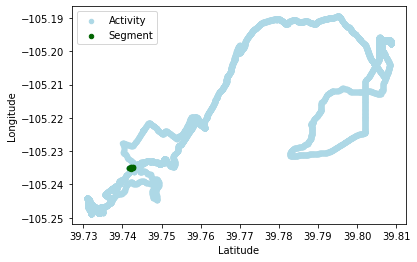

In [209]:
act_pl = activity.plot.scatter(x='Latitude', y='Longitude', color='LightBlue', label='Activity')
segment.plot.scatter(x='Latitude', y='Longitude', color='DarkGreen', label='Segment', ax=act_pl)

### Norrow the activity points to search.

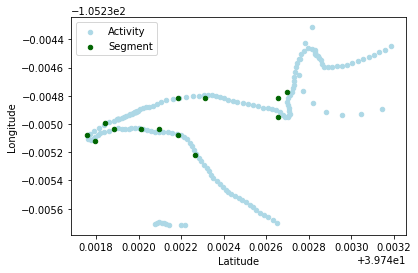

In [210]:
# Only points within the range of the segment
activity['index2'] = 1
activity['index2'] = activity.index2.cumsum()

padding = .0005 # about 55 meters 
lat_min, lat_max = segment.Latitude.min() - padding, segment.Latitude.max() + padding
lon_min, lon_max = segment.Longitude.min() - padding, segment.Longitude.max() + padding

inbound = (activity.Latitude.between(lat_min, lat_max, inclusive=False) & activity.Longitude.between(lon_min, lon_max, inclusive=False))
activity['inbound'] = inbound

act_pl = activity[activity.inbound == True].plot.scatter(x='Latitude', y='Longitude', color='LightBlue', label='Activity')
segment.plot.scatter(x='Latitude', y='Longitude', color='DarkGreen', label='Segment', ax=act_pl)

### Find consecutive points.
As you can see this does not really help. It makes sense, any activity pioints in the range will be consecutive
unless it is just one point on the activity path. In this case it did not remove any points.

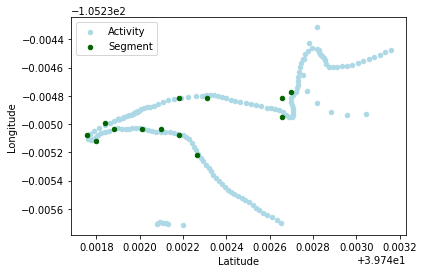

In [211]:
# Find concecutive. Need to be more careful about getting begining and ending points
activity['inbound'] = inbound
activity['consecutive'] = activity[activity.inbound == True].index2.diff() == 1
activity[activity.consecutive == True]

act_pl = activity[activity.consecutive==True].plot.scatter(x='Latitude', y='Longitude', color='LightBlue', label='Activity')
segment.plot.scatter(x='Latitude', y='Longitude', color='DarkGreen', label='Segment', ax=act_pl)

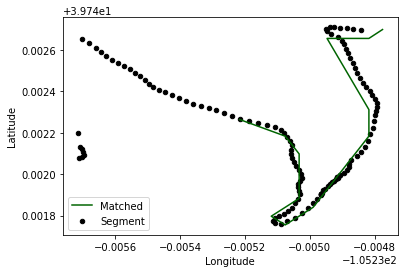

In [393]:
import numpy as np
from numpy.linalg import norm

segment['lat_shift'] = segment['Latitude'].shift(-1)
segment['lon_shift'] = segment['Longitude'].shift(-1)


def dist_to_closest_segments(activity_point=None, segment=None):
    dist = {}
    dist2 = set()
    p3 = activity_point[['Latitude', 'Longitude']]
    alat = activity_point[['Latitude']].values
    alon = activity_point[['Longitude']].values
#     print(p3)
    for idx, s in segment[:][['Latitude','lat_shift', 'Longitude', 'lon_shift']].iterrows():
        slat, slats, slon, slons = s
        # is it in the point "between" the segments points?
#         print(alat, alon, slat, slats, slon, slons)
        if min(lat, slats) <= alat <= max(lat, slats) or min(lon, slons) <= alon <= max(lon, slons):
            p1 = np.array([lat, lon])
            p2 = np.array([lats, lons])
            n = norm(p2-p1)
            c = np.cross(p2 - p1, p1 - p3)
            d = np.abs(norm(c) / n)
    #         if d < .00004:
    #             print(d)
    #         print(p1,p2, p3, n, c)
#             dist.update({idx: d})
            dist2.add(d)
        else:
            dist2.add(999999999)
#             print(dist2)
    return min(dist2)
#     return dist[min(dist, key=dist.get)]
        
        

# dist_to_closest_segments((1,2), segment)      

activity['line_dist_idx'] = activity[activity.consecutive==True].apply(dist_to_closest_segments, segment=segment, axis=1)
line_dist = activity[(activity.consecutive==True) & (0 <= activity.line_dist_idx) & (activity.line_dist_idx <= .0006)]

# act_pl = activity[(activity.consecutive==True)].plot.scatter(x='Longitude', y='Latitude', color='LightBlue', label='Activity')
act_p2 = line_dist.plot.scatter(x='Longitude', y='Latitude', color='Black', label='Matched')
segment.plot.line(x='Longitude', y='Latitude', color='DarkGreen', label='Segment', ax=act_p2)
# s1 = segment.plot.line(x='Longitude', y='Latitude', color='DarkBlue', label='Segment')
# segment.plot.line(x='lon_shift', y='lat_shift', color='DarkGreen', label='Segment', ax=s1)


In [351]:
from ipyleaflet import  Map, AntPath, basemaps, LocalTileLayer
m = Map(center=(39.737208, -105.245470), zoom=15)
m.add_layer(LocalTileLayer(path="https://tiles.wmflabs.org/hikebike/{z}/{x}/{y}.png"))


ant_path = AntPath(
    locations=line_dist[['Latitude','Longitude']].values.tolist(),
        dash_array=[1, 10],
        delay=1000,
        color='#000000',
        pulse_color='#3f6fba'
)

seg_path = AntPath(
    locations=segment[['Latitude','Longitude']].values.tolist(),
        dash_array=[1, 10],
        delay=1000,
        color='#7590ba',
        pulse_color='#3f6fba'
)

act_path = AntPath(
    locations=activity[activity.consecutive==True][['Latitude','Longitude']].values.tolist(),
        dash_array=[1, 10],
        delay=1000,
        color='#00ff00',
        pulse_color='#3f6fba'
)

m.add_layer(ant_path)
m.add_layer(seg_path)
m.add_layer(act_path)

m

Map(center=[39.737208, -105.24547], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [ ]:
import numpy as np
from numpy.linalg import norm

segment['lat_diff'] = segment['Latitude'].diff()
segment['lon_diff'] = segment['Longitude'].diff()
segment['diff'] = list(segment[['lat_diff', 'lon_diff']].itertuples(index=False, name=None))

for s in segment.iloc[1:][['Latitude', 'Longitude', 'diff', 'lat_diff', 'lon_diff']].values:
    dist = []
    for idx, a in activity[['Latitude', 'Longitude']].iterrows():
        p2 = np.array([s[3], s[4]])
        p1 = np.array([s[0], s[1]])
#         print(p1, p2, a)
        # compute distance from 
        c = np.cross(p2 - p1, p1 - a)
        n = norm([p2-p1])
        if n == 0: #using current precision the distance is basiclly 0 form 
#                 print('div 0', cross)
            d = 0
        else:
            d = np.abs(c / n)
        dist.append(d)
    activityiloc[idx]['dist_line'] = activity['dist_line'].apply(lambda x: min(x, min(dist)))
        
#         activity.iloc[idx]['dist_from_seg'] = d

In [ ]:
activity

In [183]:
from scipy.spatial import distance

a = distance.cdist(segment[['Latitude', 'Longitude']], activity[['Latitude', 'Longitude']], 'euclidean')
a.shape

(13, 10478)

In [182]:
import numpy as np

arr = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])

arr.shape

(2, 5)

In [156]:
activity['altitude_change'] = activity.Altitude.diff()
activity["shift_Longitude"] = activity.shift(1)["Longitude"]
activity["shift_Latitude"] = activity.shift(1)["Latitude"]

activity["distance_between"] = activity.apply(
            lambda x: sqrt(
                (haversine((x["Latitude"], x["Longitude"]),
                           (x["shift_Latitude"], x["shift_Longitude"]),unit="m",)** 2
                 + x["altitude_change"] ** 2)),axis=1)

In [22]:
        # This is the flat distance between points
        self.df["distance_between"] = self.df.apply(
            lambda x: sqrt(
                (haversine((x["Latitude"], x["Longitude"]),
                           (x["shift_Latitude"], x["shift_Longitude"]),unit="m",)** 2
                 + x["altitude_change"] ** 2)),axis=1)
        self.df.drop(['shift_Longitude', 'shift_Latitude'], axis=1)
        self.total_distance = self.df["distance_between"].sum()
        self.df['distance'] = self.df['distance_between'].cumsum()

1.0

In [117]:
activity[activity.consecutive == True]

,Latitude,Longitude,index2,consecutive,inbound


In [150]:
pd.read_csv("../tests/test_data/segment_test_1b.csv")

,Unnamed: 0,Latitude,Longitude,lat_diff,lon_diff,diff
0,0,39.808649,-105.197730,NaN,NaN,"(nan, nan)"
1,1,39.808649,-105.197730,0.000000e+00,0.000000,"(0.0, 0.0)"
2,2,39.808645,-105.197678,-4.000000e-06,0.000052,"(-4.0000000041118255e-06, 5.200000001082117e-05)"
3,3,39.808644,-105.197640,-1.000000e-06,0.000038,"(-9.999999974752427e-07, 3.8000000003535206e-05)"
4,4,39.808642,-105.197600,-2.000000e-06,0.000040,"(-2.0000000020559128e-06, 3.999999999848569e-05)"
...,...,...,...,...,...,...
10473,10473,39.808626,-105.197737,0.000000e+00,0.000000,"(0.0, 0.0)"
10474,10474,39.808626,-105.197737,0.000000e+00,0.000000,"(0.0, 0.0)"
10475,10475,39.808626,-105.197737,0.000000e+00,0.000000,"(0.0, 0.0)"
10476,10476,39.808626,-105.197737,0.000000e+00,0.000000,"(0.0, 0.0)"


In [267]:
x = {'A':1}
x.update({'B':2})
min(x, key=x.get)

'A'

In [309]:
! python -m pip install ipyleaflet